# Training from data

This notebook walks you through training a normalizing flow by gradient descent when data is available.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko

## Dataset

We consider the Two Moons dataset.

In [2]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack((
        torch.cos(theta) + label - 1 / 2,
        torch.sin(theta) + label / 2 - 1 / 4,
    ), axis=-1)

    return torch.normal(x, sigma), label

samples, labels = two_moons(16384)

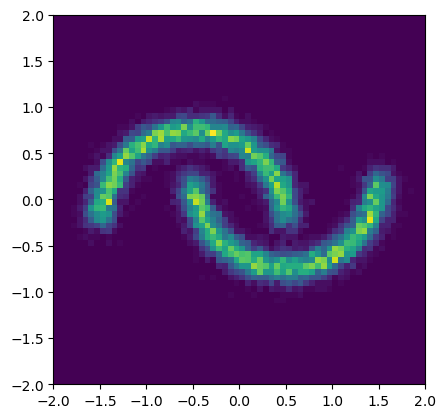

In [3]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [4]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

## Unconditional flow

We use a neural spline flow (NSF) as density estimator $q_\phi(x)$.

In [5]:
flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

The objective is to minimize the Kullback-Leibler (KL) divergence between the true data distribution $p(x)$ and the modeled distribution $q_\phi(x)$.

$$
    \begin{align}
        \arg \min_\phi & ~ \mathrm{KL} \big( p(x) || q_\phi(x) \big) \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \left[ \log \frac{p(x)}{q_\phi(x)} \right] \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \big[ -\log q_\phi(x) \big]
    \end{align}
$$

In [6]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for x, label in trainloader:
        loss = -flow().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f'({epoch})', losses.mean().item(), '±', losses.std().item())

(0) 1.3520090579986572 ± 0.25871574878692627
(1) 1.147993564605713 ± 0.1022777259349823
(2) 1.1174802780151367 ± 0.09858577698469162
(3) 1.0956673622131348 ± 0.1021992415189743
(4) 1.0934643745422363 ± 0.09762168675661087
(5) 1.0758651494979858 ± 0.09098420292139053
(6) 1.0708422660827637 ± 0.09713941812515259
(7) 1.0695130825042725 ± 0.09372557699680328


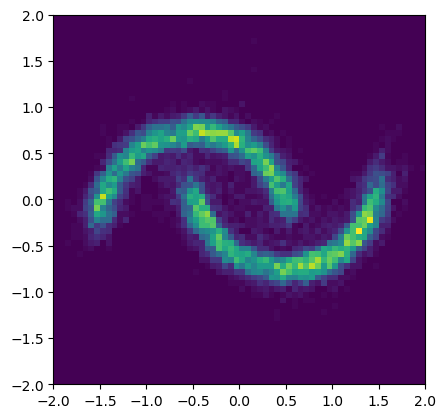

In [7]:
samples = flow().sample((16384,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

## Conditional flow

We use a neural spline flow (NSF) as density estimator $q_\phi(x | c)$, where $c$ is the label.

In [8]:
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))

In [9]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for x, label in trainloader:
        c = label.unsqueeze(dim=-1)

        loss = -flow(c).log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f'({epoch})', losses.mean().item(), '±', losses.std().item())

(0) 0.7147052884101868 ± 0.4756987988948822
(1) 0.40776583552360535 ± 0.10716820508241653
(2) 0.3866541087627411 ± 0.10318031907081604
(3) 0.37453195452690125 ± 0.10870178788900375
(4) 0.3634893000125885 ± 0.10033125430345535
(5) 0.36492055654525757 ± 0.10960724204778671
(6) 0.3537733554840088 ± 0.09780355542898178
(7) 0.3559333086013794 ± 0.1038535088300705


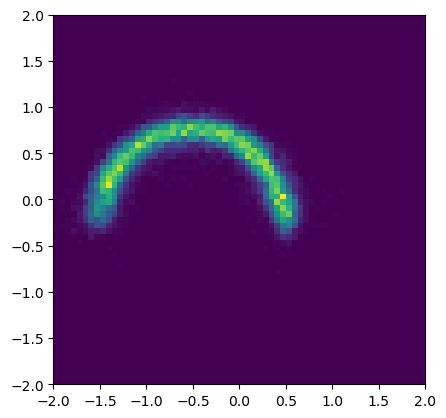

In [10]:
samples = flow(torch.tensor([0.0])).sample((16384,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

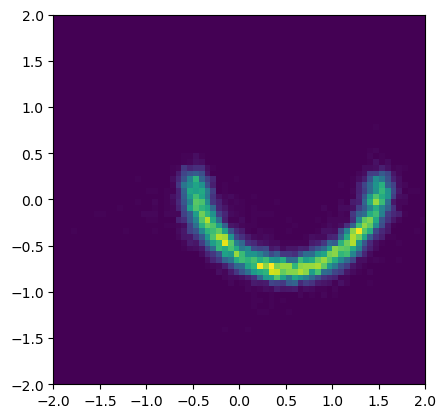

In [11]:
samples = flow(torch.tensor([1.0])).sample((16384,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()